In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

import shap

import json 
from tools import create_x_y

In [8]:
def importances_from_lag(x, col_names):
    lag = int(len(x) / len(col_names))
    len_col = len(col_names)
    imp = {
        col_names[i]: sum(x[i * lag : (i + 1) * lag]) / lag
        for i in range(len_col)
    }
    #imp = dict(sorted(imp.items(), key=lambda item: item[1], reverse=True))
    return imp

def shap_features(model, train, test):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(test)
    shap.force_plot(explainer.expected_value[0], shap_values[0], test)
    return

def save_shapley_plot(sp, name, title, cols):
    import seaborn as sns
    shap_abs = np.abs(sp).mean(axis=0)
    importances = importances_from_lag(shap_abs, cols) 

    x_axis = list(importances.keys())
    y_axis = [float(i) for i in importances.values()]
    figure = plt.gcf()
    figure.set_size_inches(9, 6)
    sns.barplot(y=x_axis, x=y_axis).set_title(title)
    
    plt.savefig(f'../plots/shap/{name}.pdf')

In [3]:
def measure(x, y):

    rf = RandomForestClassifier(random_state=42)

    params = {
        "n_estimators": [200, 400, 600],
        "max_depth": [4, 6, 8],
        "criterion": ["gini", "entropy"],
    }

    time_split = TimeSeriesSplit(n_splits=5)

    clf_search = GridSearchCV(
        rf,
        param_grid=params,
        cv=time_split,
        verbose=1,
        n_jobs=-1,
    )

    split = int(0.8 * len(x))
    clf_search.fit(x[:split], y[:split])
    y_pred = clf_search.predict(x[split:])
    f1 = f1_score(y[split:], y_pred)
    acc = accuracy_score(y[split:], y_pred)
    roc = roc_auc_score(y[split:], y_pred)

    return round(f1, 3), round(acc, 3), round(roc, 3), clf_search.best_estimator_


In [73]:
# ===== BASELINE =====

full_names = {
    "amzn": "Amazon",
   "aapl": "Apple",
   "msft": "Microsoft",
   "tsla": "Tesla",
   "goog": "Google (GOOG)",
   "googl": "Google (GOOGL)",
}
acc = {}
roc = {}
f1_metric = {}


for company in full_names.keys():
    df = pd.read_csv(f"../datasets/v3/binned/{company}.csv")
    OTHER_COLS = ["open", "high", "close", "vol"]
    print(OTHER_COLS)
    acc[company] = {}
    roc[company] = {}
    f1_metric[company] = {}


    for lag in [1, 2, 3, 6, 8]:
        x, y = create_x_y(df, x_cols=["open", "close", "vol", "high"], y_col="bin_2", lag=lag)
        print(f"Starting {company}, {lag}.")
        acc[company][lag], f1_metric[company][lag], roc[company][lag], model = measure(
            x, y
        )
        
with open(f"../results/v3/RF_base.txt", "w") as file:
    to_write = "Acc: " + json.dumps(acc) + " F1: " + json.dumps(f1_metric) + " ROC: " + json.dumps(roc)
    file.write(json.dumps(to_write))

['open', 'high', 'close', 'vol']
Starting amzn, 1.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting amzn, 2.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting amzn, 3.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting amzn, 6.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting amzn, 8.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
['open', 'high', 'close', 'vol']
Starting aapl, 1.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting aapl, 2.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting aapl, 3.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting aapl, 6.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting aapl, 8.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
['open', 'high', 'close', 'vol']
Starting msft, 1.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting msft, 2.
Fitting 5 fold

In [74]:
# ===== all =====

full_names = {
    "amzn": "Amazon",
    "aapl": "Apple",
    "msft": "Microsoft",
    "tsla": "Tesla",
    "goog": "Google (GOOG)",
    "googl": "Google (GOOGL)",
}
weight = "no_weight"
acc = {}
roc = {}
f1_metric = {}


for company in full_names.keys():
    df = pd.read_csv(f"../datasets/v3/binned/{company}.csv")
    VITAL_COLS = ["post_date", "ticker", "bin_2", "bin_3"]
    OTHER_COLS = [i for i in df.columns if i not in VITAL_COLS]
    print(OTHER_COLS)
    acc[company] = {}
    roc[company] = {}
    f1_metric[company] = {}


    for lag in [1, 2, 3, 6, 8]:
        x, y = create_x_y(df, x_cols=OTHER_COLS, y_col="bin_2", lag=lag)
        print(f"Starting {company}, {lag}.")
        acc[company][lag], f1_metric[company][lag], roc[company][lag], model = measure(
            x, y
        )
        #explainer = shap.TreeExplainer(model)
        #split = int(0.8 * len(x))
        #sp = explainer.shap_values(np.array(x[:split]))
        
        #save_shapley_plot(
        #    sp,
        #    f"{company}",
        #    f"{full_names[company]} - Shapley",
        #    OTHER_COLS,
        #)
with open(f"../results/v3/RF_all.txt", "w") as file:
    to_write = "Acc: " + json.dumps(acc) + " F1: " + json.dumps(f1_metric) + " ROC: " + json.dumps(roc)
    file.write(json.dumps(to_write))

['open', 'high', 'low', 'close', 'vol', 'comment_num_sum', 'comp_max', 'comp_mean', 'comp_median', 'comp_min', 'comp_std', 'is_negative_sum', 'is_neutral_sum', 'is_positive_sum', 'like_num_sum', 'neg_max', 'neg_mean', 'neg_median', 'neg_min', 'neg_std', 'neu_max', 'neu_mean', 'neu_median', 'neu_min', 'neu_std', 'count', 'pos_max', 'pos_mean', 'pos_median', 'pos_min', 'pos_std', 'retweet_num_sum', 'relative_count', 'diffs']
Starting amzn, 1.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting amzn, 2.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting amzn, 3.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting amzn, 6.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting amzn, 8.
Fitting 5 folds for each of 18 candidates, totalling 90 fits
['open', 'high', 'low', 'close', 'vol', 'comment_num_sum', 'comp_max', 'comp_mean', 'comp_median', 'comp_min', 'comp_std', 'is_negative_sum', 'is_neutral_sum', 'is_positive_sum',

AMZN 3
AAPL 6
MSFT 1
TSLA 8
GOOG 1
GOOGL 6


['open', 'high', 'low', 'close', 'vol', 'comment_num_sum', 'comp_max', 'comp_mean', 'comp_median', 'comp_min', 'comp_std', 'is_negative_sum', 'is_neutral_sum', 'is_positive_sum', 'like_num_sum', 'neg_max', 'neg_mean', 'neg_median', 'neg_min', 'neg_std', 'neu_max', 'neu_mean', 'neu_median', 'neu_min', 'neu_std', 'count', 'pos_max', 'pos_mean', 'pos_median', 'pos_min', 'pos_std', 'retweet_num_sum', 'relative_count', 'diffs']
Starting googl, 6.
Fitting 5 folds for each of 18 candidates, totalling 90 fits


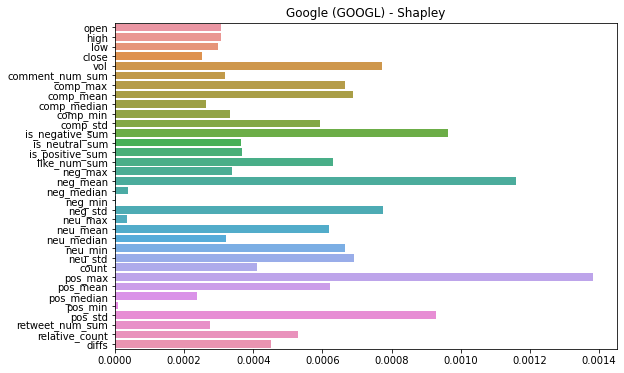

In [14]:
full_names = {
    #"amzn": "Amazon",
    #"aapl": "Apple",
    #"msft": "Microsoft",
    #"tsla": "Tesla",
    #"goog": "Google (GOOG)",
    "googl": "Google (GOOGL)",
}

lag_comp = {
    "amzn": 3,
    "aapl": 6,
    "msft": 1,
    "tsla": 8,
    "goog": 1,
    "googl": 6, 
}

acc = {}
roc = {}
f1_metric = {}

for company in full_names.keys():
    df = pd.read_csv(f"../datasets/v3/binned/{company}.csv")
    VITAL_COLS = ["post_date", "ticker", "bin_2", "bin_3"]
    OTHER_COLS = [i for i in df.columns if i not in VITAL_COLS]
    print(OTHER_COLS)
    acc[company] = {}
    roc[company] = {}
    f1_metric[company] = {}


    lag = lag_comp[company]
    x, y = create_x_y(df, x_cols=OTHER_COLS, y_col="bin_2", lag=lag)
    print(f"Starting {company}, {lag}.")
    acc[company][lag], f1_metric[company][lag], roc[company][lag], model = measure(
        x, y
    )
    explainer = shap.TreeExplainer(model)
    split = int(0.8 * len(x))
    sp = explainer.shap_values(np.array(x[:split]))
    sp = np.array(sp)[0]
    save_shapley_plot(
       sp,
       f"{company}",
       f"{full_names[company]} - Shapley",
       OTHER_COLS,
    )

In [1]:
len(['open', 'high', 'low', 'close', 'vol', 'comment_num_sum', 'comp_max', 'comp_mean', 'comp_median', 'comp_min', 'comp_std', 'is_negative_sum', 'is_neutral_sum', 'is_positive_sum', 'like_num_sum', 'neg_max', 'neg_mean', 'neg_median', 'neg_min', 'neg_std', 'neu_max', 'neu_mean', 'neu_median', 'neu_min', 'neu_std', 'count', 'pos_max', 'pos_mean', 'pos_median', 'pos_min', 'pos_std', 'retweet_num_sum', 'relative_count', 'diffs'])

34